# Segmentacja danych rastrowych metodami uczenia maszynowego
### Opis
W poniższym notatniku przeprowadzony zostanie proces segmentacji danych rastrowych w oparciu o metody nadzorowanego uczenia maszynowego i ręcznie utworzone próbki uczące. Za dane wejściowe posłuży raster uzyskany na podstawie danych pochodzących z satelity Sentinel-2. W celu dostarczenia danych uczących wykorzystano bibliotekę ipyleaflet zdolną wyświetlić podgląd obrazu na interaktywnej mapie. Wybrany zostanie obszar reprezentujący wodę oraz obszar reprezentujący ląd. Model nauczony na podstawie tych danych będzie ostatecznie wykorzystany do segmentacji całego rastra.
### Narzędzia/biblioteki
__geopandas__ - Przetwarzanie danych przestrzennych<br>
__shapely__ - Operacje na danych geometrycznych <br>
__pandas__ - Przetwarzanie danych w formie tabelarycznej<br>
__numpy__ - Operacje matematyczne na danych<br>
__ipyleaflet__ - wizualizacja i interakcja z danymi przestrzennymi <br>
__rasterio__ - odczyt i manipulacja danymi rastrowymi <br>
__scikit-learn__ - biblioteka implemetnująca algorytmy uczenia maszynowego. Posiada ona szeroki wybór algorytmów uczenia jak i kontroli uzyskanych wyników.
### Literatura
Dokumentacja rasterio - https://rasterio.readthedocs.io/en/latest/ <br>
Dokumentacja scikit_learn - https://scikit-learn.org/stable/ <br>
Notatnik - [biblioteka ipyleaflet](jupyter_geovisualization.ipynb) <br>
Notatnik - [biblioteka geopadnas](geopandas_basics.ipynb) <br>
Notatnik - [biblioteka scikit-learn](scikit-learn_basics.ipynb) <br>

## Import potrzebnych bibliotek

In [17]:
import geopandas as gpd
from shapely.geometry import shape

import pandas as pd
import numpy as np

from ipyleaflet import Map, Marker, GeoJSON, GeoData, ImageOverlay, DrawControl, FullScreenControl
from sidecar import Sidecar

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import rasterio as rast
from rasterio.plot import show
from rasterio import warp

## Wczytanie rastra
Pierwszym krokiem jest wczytanie testowego rastra, na którym przeprowadzony będzie proces klasyfikacji. Po wczytaniu pobierane są przydatne dane takie jak kod EPSG układu rastra (`image.crs.data['init']`) i współrzędne jego obwiedni (`image.bounds`).

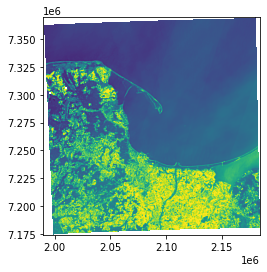

<AxesSubplot:>

In [18]:
file_name = 'example_data/RGB_60.tif'
image = rast.open(file_name)
epsg = image.crs.data['init']
bbox = image.bounds
show(image)

## Wyświetlenie rastra na mapie
Krokiem przygotowawczym do wyświetlenia rastra na mapie jest transformacja jego prostokąta ograniczającego do układu `EPSG:4326`, gdyż w tym układzie biblioteka ipyleaflet przyjmuje dane wejściowe. Posłuży do tego funkcja rasterio `transform_bounds` (https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html?highlight=transform_bounds#rasterio.warp.transform_bounds)

In [19]:
bbox = warp.transform_bounds(image.crs, rast.crs.CRS.from_epsg(
    4326), bbox.left, bbox.bottom, bbox.right, bbox.top)

Następnie, należy zdefiniować obiekt reprezentujący mapę. Centrum widoku ustawiono na środek prostokąta ograniczającego raster:
```python
center=((bbox[1]+bbox[3])/2, (bbox[0]+bbox[2])/2)
```

In [20]:
m = Map(center=((bbox[1]+bbox[3])/2, (bbox[0]+bbox[2])/2),
        zoom=10,
        scroll_wheel_zoom=True)
m.add_control(FullScreenControl())

Po zdefiniowaniu mapy, trzeba dodać do niej wartswę z rastrem. Posłuży do tego warstwa `ImageOverlay`. Wymaga ona podania granic rastra w parametrze `bounds` oraz jego ścieżki (`url`). Ścieżka do innego rastra może zostać pobarana z poziomu JupyterLab po kliknięciu Prawym Przyciskiem Myszy na wybrany raster i wybraniu opcji _Copu Download Link_. Ipyleaflet obsługuje obecnie pliki png i jpg.

In [21]:
image_lr = ImageOverlay(
    url="http://cenagis-example.surge.sh/RGB_60.png",
    bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2])))

m.add_layer(image_lr)

Finalnie, przy pomocy biblioteki Sidecar wystarczy wyświetlić mapę w oknie JupyterLab.

In [22]:
sc = Sidecar(title='Mapa')
with sc:
    display(m)

## Pobranie próbek uczących
Do przeprowadzenia klasyfikacji z wykorzystaniem algorytmów uczenia maszynowego niezbędne jest wskazanie próbek uczących. Pozwolą na to narzędzia do rysowania kształtów na mapie.

Możliwość interakcji z mapą poprzez rysowanie na niej kształtów geometrycznych reprezentujących próbki uczące umożliwi kontrolka `DrawControl`. Dla zachowania prostosty całego procesu pierwszy z narysowanych kształtów stanowić będzie próbkę pozytywną (powinien zawierać obszar, który ma zostać sklasyfikowany), a drugi negatywną (z obszarem innym niż ten klasyfikowany).

In [23]:
import shapely as shp
draw_control = DrawControl(
    rectangle={'shapeOptions': {'color': '#00FFFF'}},
)
m.add_control(draw_control)

shapes = []  # Container for drawed shapes coordinates


def handle_draw(self, action, geo_json):
    if action == "created":
        print(geo_json)
        # Add shape coordinates to the container
        shapes.append(shp.geometry.shape(geo_json['geometry']))


draw_control.on_draw(handle_draw)  # Attach callback

Po narysowaniu dwóch kształtów tablica `shapes` powinna zawierać dwa obiekty geometryczne typu poligonowego.

In [24]:
shapes

Pozyskane próbki można następnie przekonwertować do postaci intepretowalnej przez bibliotekę scikit-learn. W tym celu należy dokonać odpowiedniej transformacji układu współrzędnych (dane pobrane z mapy ipyleaflet znajdują się domyślnie w układzie o kodzie EPSG 4326), a następnie wyciąć z rastra wejściowego odpowiednie wartości pikseli (funkcja `mask` - https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html).

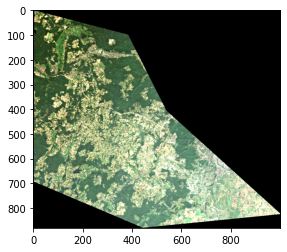

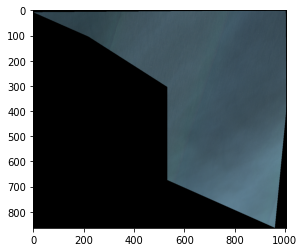

<AxesSubplot:>

In [25]:
from rasterio.mask import mask
# convert shapes container to GeoDataFrame
valid_samples = gpd.GeoDataFrame(
    crs='epsg:4326',
    geometry=[shapes[0]]).to_crs(epsg=epsg[-4:])  # transform to proper reference system

false_samples = gpd.GeoDataFrame(
    crs='epsg:4326',
    geometry=[shapes[1]]).to_crs(epsg=epsg[-4:])

# clip raster with shapes
valid_sample_raster, _ = mask(image, valid_samples.geometry, crop=True)
false_sample_raster, _ = mask(image, false_samples.geometry, crop=True)

# #convert values to pandas dataframe
show(valid_sample_raster)
show(false_sample_raster)

Przygotowane uprzednio wycinki rastra są następnie transformowane do postaci pandas `DataFrame`. Aby tego dokonać należy zmienić kształt wejściowych danych. Obecnie są to trzy macierze reprezentujące trzy kanały. W `DataFrame` powinny znaleźć się więc trzy kolumny reprezentujące wartość każdego piksela w trzech kanałach. Do zmiany wymiarów posłuży funkcja numpy `reshape` (https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) oraz `rollaxis` (https://numpy.org/doc/stable/reference/generated/numpy.rollaxis.html).

Z `DataFrame` należy też usunąć piksele stanowiące dopełnienie wyciętych fragmentów do postaci prostokąta (posiadają one wartość 0 we wszystkich trzech kanałach).
```python
valid_samples_pd = valid_samples_pd[valid_samples_pd.sum(axis=1) != 0]
```
Po nadaniu wartości klasy dla każego piksela (1 i 0) można oba zbiory połączyć uzyskująć pełny zbiór uczący.

In [26]:
valid_samples_pd = pd.DataFrame(np.rollaxis(
    valid_sample_raster, 0, 3).reshape(-1, 3))
valid_samples_pd = valid_samples_pd[valid_samples_pd.sum(axis=1) != 0]
valid_samples_pd['class'] = 1
false_samples_pd = pd.DataFrame(np.rollaxis(
    false_sample_raster, 0, 3).reshape(-1, 3))
false_samples_pd = false_samples_pd[false_samples_pd.sum(axis=1) != 0]
false_samples_pd['class'] = 0
full_samples_pd = pd.concat([valid_samples_pd, false_samples_pd])
full_samples_pd.head(10)

,0,1,2,class
1005,93,128,59,1
1006,108,130,63,1
2005,96,155,71,1
2006,90,135,64,1
2007,86,122,56,1
2008,85,116,54,1
2009,75,105,48,1
2010,47,77,33,1
3005,84,132,57,1
3006,92,138,61,1


## Uczenie modelu
Po pobraniu próbek można przystąpić do właściwego procesu uczenia modelu, który posłuży do klasyfikacji rastra. Konieczny jest podział `DataFrame` na zmienna objaśniające (X) i objaśniane (y). W tym przypadku będą to kolejno wartości pikseli i numer klasy.

Należy rozdzielić zbiór uczący na zestaw treningowy oraz testowy (szczegóły tego procesu zostały opisane w dokumentacji biblioteki scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), a następnie przeprowadzić uczenie wybranym algorytmem. Na potrzeby tego poradnika wybrano las losowy (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [27]:
x_data = full_samples_pd[full_samples_pd.columns[:3]]
y_data = full_samples_pd[full_samples_pd.columns[-1]]

In [28]:
# Prepare training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=0.6, test_size=0.4)
# Initalize ML model
model = RandomForestClassifier()
# Fit model basing on training sets
model.fit(x_train, y_train)

RandomForestClassifier()

Po ukończeniu procesu uczenia należy przeprowadzić ocenę dokładności modelu z wykorzystaniem zbioru testowego. Wynik zawiera się w przedziale <0,1>, gdzie 1 oznacza idealne przypisanie przez model klasy każdemu z pikseli.

In [29]:
# Classify test set
predictions = model.predict(x_test)
# Check accuracy of classification
score = accuracy_score(y_test, predictions)
score

0.9999723907155498

## Segmentacja rastra
Wykorzystując nauczony model można przejść do segmentacji całego rastra. w tym celu przeprowadza się proces predykcji dla tablicy wartości pikseli znajdujących się w całym wejściowym rastrze. Proces ten jest identyczny, jak w przypadku przygotowywania danych uczących do trenowania modelu.

In [30]:
image_pd = pd.DataFrame(np.rollaxis(
    image.read(), 0, 3).reshape(image.height*image.width, 3))
predicted = model.predict(image_pd)

Po predykcji klasy dla każdego piksela można ponownie użyć funkcji `reshape`, aby przywrócić oryginalny wymiar rastra.

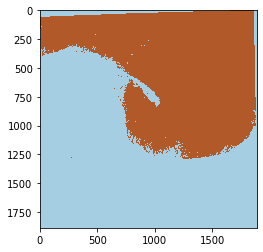

<AxesSubplot:>

In [31]:
predicted_img = predicted.reshape(image.height, image.width)
show(predicted_img, cmap='Paired_r',interpolation='nearest')

In [32]:
predicted_img[predicted_img==1]=255

Gdy wynik jest satysfakcjonujący, można zapisać go do pliku tif przy pomocy rasterio.

In [33]:
new_dataset = rast.open('classification.png', 'w', driver='PNG',
                        height=predicted_img.shape[0], width=predicted_img.shape[1],
                        count=1, dtype='uint8',
                        crs=image.crs,
                        transform=image.transform)
new_dataset.write(predicted_img, 1)
new_dataset.close()

Wizualizacja zapisanego wyniku na mapie ipyleaflet jest możliwa poprzez wprwadzenie w parametrze `url` linku pobieralnego do obrazu. W celu uzyskania takiego linku należy kliknąć prawym przyciskiem myszy na plik w eksploratorze JupyterLab, a następnie wybrać opcję `Copy Download Link` i wkleić go jako parametr `url` poniżej.

In [34]:
image_lr = ImageOverlay(
    url="https://jupyterhub.cenagis.edu.pl/user/kchoromanski/files/jupyter-notebook-tutorial/ClassicTools/classification.png?_xsrf=2%7C55643c29%7Caecd4394095326b481b3f5f1c52bcd0c%7C1651068777",
    bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2])))

m.add_layer(image_lr)

In [36]:
from ipyleaflet import LayersControl
control = LayersControl()
m.add_control(control)

To koniec analizy!